# Homework №5

Рубаненко Евгений, 595

## Подготовка

In [0]:
!apt install ffmpeg xvfb python-opengl -y

In [0]:
!pip3 install gym
!pip3 install pyvirtualdisplay
!pip3 install piglet
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip3 install torch

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [0]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [0]:
import gym
import random

import numpy as np
import matplotlib.pyplot as plt

from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    device = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    device = torch.device('cpu')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation space: Box(24,)
Action space: Box(4,)


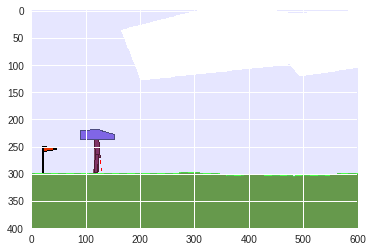

In [0]:
env = gym.make("BipedalWalker-v2").unwrapped

plt.imshow(env.render('rgb_array'))
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

## Решение

Данное задание предлагалось решать с помощью `Actor-Critic`. Чтобы разобраться в теме я прочитал следующие статьи:
1. https://hackernoon.com/intuitive-rl-intro-to-advantage-actor-critic-a2c-4ff545978752  
    Данная статья дала мне общее понимание того, в чем заключается идея `Actor-Critic`.
2. https://medium.freecodecamp.org/an-intro-to-advantage-actor-critic-methods-lets-play-sonic-the-hedgehog-86d6240171d  
    В этой статье я прочитал про математическую составляющую `Actor-Critic`.
3. https://towardsdatascience.com/reinforcement-learning-w-keras-openai-actor-critic-models-f084612cfd69  
    Объяснение алгоритма с примером кода.
4. https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py  
    Пример из официального репозитория `pytorch`.

Дальше я уже стал читать про `BipedalWalker-v2`. Где-то я прочитал, что лучшие результаты сейчас получены с помощью `DQN` и `DDPG`.
Оказалось, что `DDPG` -- это усложненный вариант `Actor-Critic`, поэтому я стал читать про этот алгоритм:
1. https://pemami4911.github.io/blog/2016/08/21/ddpg-rl.html  
    Объяснение алгоритма с примером кода.
2. https://yanpanlau.github.io/2016/10/11/Torcs-Keras.html  
    Объяснение алгоритма с примером кода.
2. https://arxiv.org/pdf/1509.02971.pdf  
    Оригинальная статья, в которой был представлен `DDPG`.

In [0]:
# Гиперпараметры
MAX_EPISODES = 5000         #  Максимальное число эпизодов
MAX_TIMESTEPS = 2000        #  Максимальное число шагов в эпизоде
BATCH_SIZE = 100            #  Сколько элементов сэмплируется из памяти
GAMMA = 0.99                #  Используется при обновлении reward
POLICY_NOISE = 0.2          #  Отвеачет за шум при обновлении политики
NOISE_CLIP = 0.5            #  Границы шума
POLICY_DELAY = 2            #  Обновление политики происходит не на каждом шаге
TAU = 0.005                 #  Параметр обновления весов
EXPLORATION_NOISE = 0.1     #  Отвечает за шум при выборе действия

In [0]:
# В DDPG обновление весов происходит по следующей формуле
# \theta^{\mu'} = \theta^{\mu'} * (1 - \tau) + \theta^{\mu} * \tau
def _update(target, source, tau):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1. - tau) + source_param.data * tau)

In [0]:
# Простая реализация ReplayBuffer.
# Практика показала, что можно не ограничивать размер буфера.
class Memory:
    def __init__(self):
        self.buffer = []

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        indexes = np.random.randint(0, len(self.buffer), size=batch_size)
        state, action, reward, next_state, done = [], [], [], [], []

        for i in indexes:
            s, a, r, s_, d = self.buffer[i]
            state.append(np.array(s, copy=False))
            action.append(np.array(a, copy=False))
            reward.append(np.array(r, copy=False))
            next_state.append(np.array(s_, copy=False))
            done.append(np.array(d, copy=False))

        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

In [0]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super().__init__()

        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, action_dim)

        self.max_action = max_action

    def forward(self, state):
        action = F.relu(self.fc1(state))
        action = F.relu(self.fc2(action))
        action = torch.tanh(self.fc3(action)) * self.max_action
        
        return action

In [0]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        self.fc1 = nn.Linear(state_dim + action_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 1)

    def forward(self, state, action):
        pair = torch.cat([state, action], dim=1)

        qvalue = F.relu(self.fc1(pair))
        qvalue = F.relu(self.fc2(qvalue))
        qvalue = self.fc3(qvalue)

        return qvalue

In [0]:
# Основная модель.
# Изначально в DDPG предлагалось использовать две пары Actor-Critic.
# Здесь реализовано в виде Actor(1)-Critic(2) (Идея из A3C).
# Оптимизатор -- Adam -- использовался в оригинальной статье
# (мне самому Adam нравится больше остальных, потому что он довольно
# агрессивный в начале).
class DDPG:
    def __init__(self, state_dim, action_dim, max_action, batch_size, gamma,
                 tau, policy_noise, noise_clip, policy_delay):
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_delay = policy_delay
        
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters())

        self.critic_1 = Critic(state_dim, action_dim).to(device)
        self.critic_1_target = Critic(state_dim, action_dim).to(device)
        self.critic_1_target.load_state_dict(self.critic_1.state_dict())
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters())

        self.critic_2 = Critic(state_dim, action_dim).to(device)
        self.critic_2_target = Critic(state_dim, action_dim).to(device)
        self.critic_2_target.load_state_dict(self.critic_2.state_dict())
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters())

        self.max_action = max_action

    def select_action(self, state):
        state = FloatTensor(state.reshape(1, -1))
        return self.actor(state).cpu().data.numpy().flatten()

    def update(self, memory, n_iter):
        for i in range(n_iter):
            state, action_, reward, next_state, done = memory.sample(self.batch_size)
            state = FloatTensor(state)
            action = FloatTensor(action_)
            reward = FloatTensor(reward).reshape((self.batch_size, 1))
            next_state = FloatTensor(next_state)
            done = FloatTensor(done).reshape((self.batch_size, 1))

            noise = FloatTensor(action_).data.normal_(0, self.policy_noise)
            noise = noise.clamp(-self.noise_clip, self.noise_clip)
            next_action = self.actor_target(next_state) + noise
            next_action = next_action.clamp(-self.max_action, self.max_action)

            target_Q1 = self.critic_1_target(next_state, next_action)
            target_Q2 = self.critic_2_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + ((1 - done) * self.gamma * target_Q).detach()

            current_Q1 = self.critic_1(state, action)
            loss_Q1 = F.mse_loss(current_Q1, target_Q)
            self.critic_1_optimizer.zero_grad()
            loss_Q1.backward()
            self.critic_1_optimizer.step()

            current_Q2 = self.critic_2(state, action)
            loss_Q2 = F.mse_loss(current_Q2, target_Q)
            self.critic_2_optimizer.zero_grad()
            loss_Q2.backward()
            self.critic_2_optimizer.step()

            if i % self.policy_delay == 0:
                actor_loss = -self.critic_1(state, self.actor(state)).mean()

                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                _update(self.actor_target, self.actor, self.tau)
                _update(self.critic_1_target, self.critic_1, self.tau)
                _update(self.critic_2_target, self.critic_2, self.tau)

In [0]:
# Обучение модели (стандартное итерирование по эпизодам / шагам)
def train():
    env = gym.make('BipedalWalker-v2')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    ddpg = DDPG(
        state_dim=state_dim,
        action_dim=action_dim,
        max_action=max_action,
        batch_size=BATCH_SIZE,
        gamma=GAMMA,
        tau=TAU,
        policy_noise=POLICY_NOISE,
        noise_clip=NOISE_CLIP,
        policy_delay=POLICY_DELAY
    )
    memory = Memory()

    avg_reward = 0

    for episode in range(1, MAX_EPISODES + 1):
        state = env.reset()

        for t in range(MAX_TIMESTEPS):
            action = ddpg.select_action(state)
            action = action + np.random.normal(0, EXPLORATION_NOISE, size=action_dim)
            action = action.clip(env.action_space.low, env.action_space.high)

            next_state, reward, done, _ = env.step(action)
            memory.add((state, action, reward, next_state, float(done)))
            state = next_state

            avg_reward += reward

            if done or t == (MAX_TIMESTEPS - 1):
                ddpg.update(memory, t)
                break

        if (avg_reward / 10) >= 300:
            print('Solved!')
            break

        if episode % 10 == 0:
            print('Episode: {}\tAverage Reward: {:.2f}'.format(episode, avg_reward / 10))
            avg_reward = 0

In [0]:
# Обучение занимает где-то 4-5 часов
# Оно не очень стабильно (иногда из-за плохого начала сходится очень медленно)
train()

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode: 10	Average Reward: -116.64
Episode: 20	Average Reward: -129.62
Episode: 30	Average Reward: -113.84
Episode: 40	Average Reward: -117.32
Episode: 50	Average Reward: -118.74
Episode: 60	Average Reward: -140.47
Episode: 70	Average Reward: -131.91
Episode: 80	Average Reward: -139.98
Episode: 90	Average Reward: -115.80
Episode: 100	Average Reward: -112.53
Episode: 110	Average Reward: -109.13
Episode: 120	Average Reward: -119.49
Episode: 130	Average Reward: -118.80
Episode: 140	Average Reward: -117.31
Episode: 150	Average Reward: -136.19
Episode: 160	Average Reward: -136.62
Episode: 170	Average Reward: -110.35
Episode: 180	Average Reward: -101.55
Episode: 190	Average Reward: -116.47
Episode: 200	Average Reward: -114.29
Episode: 210	Average Reward: -105.17
Episode: 220	Average Reward: -83.9